In [ ]:
!pip install timm
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torch.nn as nn
import timm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import torchvision.transforms as transforms
from tqdm import tqdm

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from PIL import Image  # PIL is better for handling image transformations

class DefectDataset(Dataset):
    def __init__(self, folder, transform=None):
        """
        Args:
            folder (str): Path to the folder containing images and their ground truth labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.folder = folder
        self.transform = transform
        # filtering out _GT.png files so that we can only work with base images
        self.images = [f for f in os.listdir(folder) if f.endswith('.png') and not f.endswith('_GT.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder, self.images[idx])
        # corresponding label (ground truth) path
        gt_name = os.path.join(self.folder, self.images[idx].replace('.png', '_GT.png'))
        
        # we are loading the image using PIL
        image = Image.open(img_name).convert('RGB')  # Convert to 3 channels (RGB)

        # loading label (ground truth) if it exists, otherwise there is no defect (label=0)
        if os.path.exists(gt_name):
            label_image = plt.imread(gt_name)
            label = int(np.max(label_image))  # binary classification
        else:
            label = 0  # defaulting to no defect if ground truth file is missing

        if self.transform:
            image = self.transform(image)

        return image, label

train_path = "/kaggle/input/iterationone/train"
test_path = "/kaggle/input/iterationone/test"
image_size = (224, 224)  # Standard input size for EfficientNet

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  #normalizing for 3 channels
    ]),
    'test': transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # normalizing for 3 channels
    ])
}

train_dataset = DefectDataset(train_path, transform=data_transforms['train'])
test_dataset = DefectDataset(test_path, transform=data_transforms['test'])

# handling Class Imbalance
labels = [train_dataset[i][1] for i in range(len(train_dataset))]  
class_counts = [labels.count(0), labels.count(1)]
class_weights = 1.0 / np.array(class_counts)  # inverse class frequency
sample_weights = [class_weights[label] for _, label in train_dataset]  # assigning weight to each sample
sampler = WeightedRandomSampler(sample_weights, len(train_dataset))  # sampling with replacement

# dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Dataset and DataLoader are ready!")


Dataset and DataLoader are ready!


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
import timm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.amp import GradScaler, autocast

# defining focal loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        # creating one-hot encoding on the same device as the logits
        targets_one_hot = torch.eye(logits.size(1), device=logits.device)[targets]
        probs = torch.softmax(logits, dim=1)
        probs_target = torch.sum(probs * targets_one_hot, dim=1)

        # computing focal loss
        log_probs = -torch.log(probs_target + 1e-9)
        focal_loss = self.alpha * ((1 - probs_target) ** self.gamma) * log_probs

        # reducing
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# setting up our parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion_focal = FocalLoss(alpha=0.25, gamma=2.0)
efficientnet_model_name = "efficientnet_b1"  
num_classes_binary = 2
learning_rate_focal = 1e-4
batch_size_focal = 32
num_epochs_focal = 5

# extracting our labels 
train_labels_focal = [train_dataset[i][1] for i in range(len(train_dataset))]

# stratifiedKFold for 5-fold cross-validation
skf_focal = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results_focal = []

#training with Focal Loss
for fold, (train_idx_focal, val_idx_focal) in enumerate(skf_focal.split(np.arange(len(train_labels_focal)), train_labels_focal)):
    print(f"\nTraining Fold {fold + 1}")

    # creating subsets for training and validation
    train_subset_focal = torch.utils.data.Subset(train_dataset, train_idx_focal)
    val_subset_focal = torch.utils.data.Subset(train_dataset, val_idx_focal)

    # WeightedRandomSampler for imbalance handling
    train_labels_fold = [train_dataset[i][1] for i in train_idx_focal]
    class_counts_focal = [train_labels_fold.count(0), train_labels_fold.count(1)]
    class_weights_focal = 1.0 / torch.tensor(class_counts_focal, dtype=torch.float32)
    sample_weights_focal = [class_weights_focal[label] for label in train_labels_fold]
    train_sampler_focal = WeightedRandomSampler(sample_weights_focal, len(train_idx_focal), replacement=True)

    train_loader_focal = DataLoader(train_subset_focal, batch_size=batch_size_focal, sampler=train_sampler_focal)
    val_loader_focal = DataLoader(val_subset_focal, batch_size=batch_size_focal, shuffle=False)

    # initializing EfficientNet model
    model_focal = timm.create_model(efficientnet_model_name, pretrained=True, num_classes=num_classes_binary).to(device)
    optimizer_focal = torch.optim.Adam(model_focal.parameters(), lr=learning_rate_focal)
    scaler_focal = GradScaler()

    # this here is our training loop
    for epoch in range(num_epochs_focal):
        model_focal.train()
        running_loss_focal = 0.0
        for inputs, labels in tqdm(train_loader_focal, desc=f"Epoch {epoch + 1} Training"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer_focal.zero_grad()
            with autocast(device_type="cuda"):
                outputs = model_focal(inputs)
                loss = criterion_focal(outputs, labels)
            scaler_focal.scale(loss).backward()
            scaler_focal.step(optimizer_focal)
            scaler_focal.update()
            running_loss_focal += loss.item()

        print(f"Epoch {epoch + 1}: Loss = {running_loss_focal / len(train_loader_focal):.4f}")

    # this here is our validation loop
    model_focal.eval()
    val_preds_focal, val_labels_focal = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader_focal, desc="Validation"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_focal(inputs)
            _, preds = torch.max(outputs, 1)
            val_preds_focal.extend(preds.cpu().numpy())
            val_labels_focal.extend(labels.cpu().numpy())

    # calculating metrics
    accuracy_focal = accuracy_score(val_labels_focal, val_preds_focal)
    precision_focal, recall_focal, f1_focal, _ = precision_recall_fscore_support(val_labels_focal, val_preds_focal, average='binary')
    fold_results_focal.append((accuracy_focal, precision_focal, recall_focal, f1_focal))

# getting our cross-validation results
cv_results_focal = pd.DataFrame(fold_results_focal, columns=["Accuracy", "Precision", "Recall", "F1"])
print(f"\nCross-Validation Results:\n{cv_results_focal}")
print(f"\nAverage Results:\n{cv_results_focal.mean()}")



Training Fold 1


Epoch 1 Training: 100%|██████████| 59/59 [00:25<00:00,  2.34it/s]


Epoch 1: Loss = 0.2857


Epoch 2 Training: 100%|██████████| 59/59 [00:25<00:00,  2.35it/s]


Epoch 2: Loss = 0.0519


Epoch 3 Training: 100%|██████████| 59/59 [00:25<00:00,  2.27it/s]


Epoch 3: Loss = 0.0234


Epoch 4 Training: 100%|██████████| 59/59 [00:25<00:00,  2.33it/s]


Epoch 4: Loss = 0.0312


Epoch 5 Training: 100%|██████████| 59/59 [00:25<00:00,  2.29it/s]


Epoch 5: Loss = 0.0268


Validation: 100%|██████████| 15/15 [00:04<00:00,  3.04it/s]



Training Fold 2


Epoch 1 Training: 100%|██████████| 59/59 [00:25<00:00,  2.35it/s]


Epoch 1: Loss = 0.3365


Epoch 2 Training: 100%|██████████| 59/59 [00:25<00:00,  2.28it/s]


Epoch 2: Loss = 0.0959


Epoch 3 Training: 100%|██████████| 59/59 [00:24<00:00,  2.38it/s]


Epoch 3: Loss = 0.0504


Epoch 4 Training: 100%|██████████| 59/59 [00:25<00:00,  2.31it/s]


Epoch 4: Loss = 0.0490


Epoch 5 Training: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]


Epoch 5: Loss = 0.0379


Validation: 100%|██████████| 15/15 [00:04<00:00,  3.34it/s]



Training Fold 3


Epoch 1 Training: 100%|██████████| 59/59 [00:24<00:00,  2.43it/s]


Epoch 1: Loss = 0.3896


Epoch 2 Training: 100%|██████████| 59/59 [00:24<00:00,  2.45it/s]


Epoch 2: Loss = 0.0745


Epoch 3 Training: 100%|██████████| 59/59 [00:24<00:00,  2.37it/s]


Epoch 3: Loss = 0.0352


Epoch 4 Training: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]


Epoch 4: Loss = 0.0169


Epoch 5 Training: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]


Epoch 5: Loss = 0.0131


Validation: 100%|██████████| 15/15 [00:05<00:00,  2.89it/s]



Training Fold 4


Epoch 1 Training: 100%|██████████| 59/59 [00:24<00:00,  2.38it/s]


Epoch 1: Loss = 0.3351


Epoch 2 Training: 100%|██████████| 59/59 [00:25<00:00,  2.33it/s]


Epoch 2: Loss = 0.0593


Epoch 3 Training: 100%|██████████| 59/59 [00:24<00:00,  2.42it/s]


Epoch 3: Loss = 0.0322


Epoch 4 Training: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


Epoch 4: Loss = 0.0210


Epoch 5 Training: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


Epoch 5: Loss = 0.0146


Validation: 100%|██████████| 15/15 [00:04<00:00,  3.32it/s]



Training Fold 5


Epoch 1 Training: 100%|██████████| 59/59 [00:24<00:00,  2.43it/s]


Epoch 1: Loss = 0.2780


Epoch 2 Training: 100%|██████████| 59/59 [00:24<00:00,  2.42it/s]


Epoch 2: Loss = 0.0554


Epoch 3 Training: 100%|██████████| 59/59 [00:24<00:00,  2.42it/s]


Epoch 3: Loss = 0.0182


Epoch 4 Training: 100%|██████████| 59/59 [00:24<00:00,  2.38it/s]


Epoch 4: Loss = 0.0181


Epoch 5 Training: 100%|██████████| 59/59 [00:24<00:00,  2.44it/s]


Epoch 5: Loss = 0.0120


Validation: 100%|██████████| 15/15 [00:04<00:00,  3.08it/s]


Cross-Validation Results:
   Accuracy  Precision    Recall        F1
0  0.749465   0.246269  0.673469  0.360656
1  0.768737   0.252101  0.612245  0.357143
2  0.931478   0.660714  0.740000  0.698113
3  0.920601   0.730769  0.387755  0.506667
4  0.954936   0.966667  0.591837  0.734177

Average Results:
Accuracy     0.865043
Precision    0.571304
Recall       0.601061
F1           0.531351
dtype: float64


In [ ]:
# saving the model after fine-tuning
torch.save(model_focal.state_dict(), "fine_tuned_efficientnet.pth")

Test Results:
Accuracy: 0.9502
Precision: 0.9545
Recall: 0.5727
F1 Score: 0.7159
Area Under ROC Curve: 0.7847


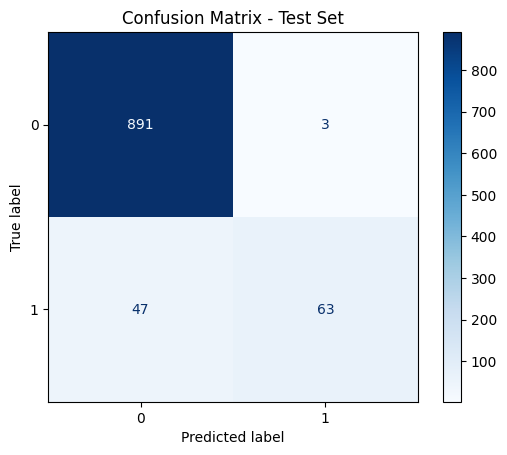

In [ ]:
#inference with the fine_tuned model
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# evaluating on the test set
model_focal.eval()
test_preds, test_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        # moving data to the appropriate device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model_focal(inputs)
        _, preds = torch.max(outputs, 1)

        # collecting predictions and true labels
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# calculating metrics
accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='binary')
roc_auc = roc_auc_score(test_labels, test_preds)

# printing metrics
print(f"Test Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Area Under ROC Curve: {roc_auc:.4f}")

# plotting our Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()


In [ ]:
import torch
import timm
import onnx

# loading our fine-tuned EfficientNet model
model = timm.create_model("efficientnet_b1", pretrained=False, num_classes=2)
model.load_state_dict(torch.load("fine_tuned_efficientnet.pth"))  
model.eval()

input_height = 224
input_width = 224

dummy_input = torch.randn(1, 3, input_height, input_width)  # Batch size: 1, Channels: 3 (RGB)

onnx_model_path = "Fine-Tuned-EfficientNet.onnx"

torch.onnx.export(
    model,
    dummy_input,
    onnx_model_path,  # saving the exported model
    opset_version=11,     
    input_names=["input"], 
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}  # supporting dynamic batch size
)

print(f"Model exported to {onnx_model_path} successfully!")

# checking the exported ONNX model for correctness
try:
    onnx_model = onnx.load(onnx_model_path)  
    onnx.checker.check_model(onnx_model)  
    print("ONNX model is valid!")
except onnx.onnx_cpp2py_export.checker.ValidationError as e:
    print(f"ONNX model is invalid: {e}")


/tmp/ipykernel_30/4042318369.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fine_tuned_efficientnet.pth"))  # Replace with the path to

Model exported to Fine-Tuned-EfficientNet.onnx successfully!
ONNX model is valid!
